# 05. 소프트맥스 회귀로 MNIST 데이터 분류하기

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [3]:
# for reproducibility
# 랜덤 시드를 고정!
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
#하이퍼파라미터 변수로 설정
# hyperparameters
training_epochs = 15
batch_size = 100 #총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어져 있습니다. 레이블은 0부터 9까지 총 10개입니다.

### torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있습니다.


https://pytorch.org/vision/stable/datasets.html#mnist

In [5]:
#MNIST dataset download
mnist_train = dsets.MNIST(root= "MNIST_datat", 
                          train = True, transform= transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root= "MNIST_datat", 
                          train = False, transform= transforms.ToTensor(), download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_datat/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_datat/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_datat/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_datat/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_datat/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_datat/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_datat/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_datat/MNIST/raw



첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로입니다. 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받습니다. 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해줍니다. 네번째 인자 download는 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미입니다.

이렇게 데이터를 다운로드했다면 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더(DataLoader)를 사용합니다.

In [7]:
#dataset loader로 data batch크기만큼 로드
data_loader = DataLoader(dataset=mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)

이때 DataLoader에는 4개의 인자가 있습니다. 첫번째 인자인 dataset은 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미합니다.

drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

In [8]:
#모델 설계
#이미지는 아래와 같이 28 픽셀 × 28 픽셀의 이미지 ->  28 픽셀 × 28 픽셀 = 784 픽셀이므로, 각 이미지를 총 784의 원소를 가진 벡터로 만들어줄겁니다.
#-> 총 784개의 특성을 가진 샘플이 된다.
# input_dim은 784이고, output_dim은 10

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10) 

    def forward(self, x):
        return self.linear(x)

model = MNISTClassifier()

#비용함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#training
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader: #batch
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28) #X는 for문에서 호출될 때는 (배치 크기 × 1 × 28 × 28)의 크기를 가지지만, view를 통해서 (배치 크기 × 784)의 크기로 변환
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')


Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577745
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404700
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456524
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515589
Epoch: 0011 cost = 0.281914085
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422735
Learning finished


Accuracy: 0.8883000016212463
Label:  9
Prediction:  9


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


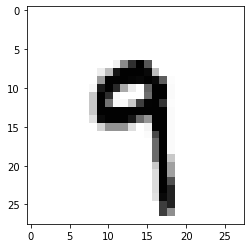

In [12]:
# 테스트 데이터를 사용하여 모델을 테스트한다.

with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.